#1. Mounting Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls -la "/content/gdrive/My Drive"

ls: '/content/gdrive/My Drive/deepfake': No such file or directory
total 32
drwx------ 2 root root 4096 Jan 29  2020 'Colab Notebooks'
drwx------ 2 root root 4096 May 28  2020  CV
drwx------ 2 root root 4096 Jul 18  2020  CV2
drwx------ 2 root root 4096 May  3 14:38  darknet
drwx------ 2 root root 4096 May  3 14:29  darknet1
lrw------- 1 root root    0 Mar 11 04:04  deepfake -> /content/gdrive/.shortcut-targets-by-id/1TIjufuJdPgkzvCQ3G1mICQZVCxWbCOFX/deepfake
drwx------ 2 root root 4096 Sep  5  2020  MLDL
drwx------ 2 root root 4096 Nov  2  2020  song
drwx------ 2 root root 4096 Jul 14  2020  test


#2. GPU Setup

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

#3. Setup

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import cv2

# Define Constants
batch_size = 128
num_classes = 0
epochs = 100
CW = 32  # 이미지의 width
CH = 32  # 이미지의 height
CD = 3   # 이미지의 channel
model_name = 'fruit_custom.h5'  # 저장할 Keras 모델 파일명
COLAB_DARKNET_PATH = '/content/gdrive/MyDrive/darknet'
YOLO_FORMAT_PATH = COLAB_DARKNET_PATH + '/custom/'
classes = []

train_images = []
train_labels = []
test_images = []
test_labels = [] 

In [ ]:
# Sample 이미지를 display 해주는 함수
def show_sample(images, labels, sample_count=25):
  # Create a square with can fit {sample_count} images
  grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
  grid_count = min(grid_count, len(images), len(labels))
  
  plt.figure(figsize=(2*grid_count, 2*grid_count))
  for i in range(sample_count):
    plt.subplot(grid_count, grid_count, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.xlabel(labels[i])
  plt.show()

# Download a file if you're using Colab,
def download(path):
  try:
    from google.colab import files
    files.download(path)
  except ImportError:
    import os
    print('Error download:', os.path.join(os.getcwd(), path))

# YOLO 좌표로부터 그림에서 object의 box 좌표를 구하는 함수 
def getROI(size, box):
    width_ratio = size[1]
    height_ratio = size[0]
    x = float(box[1]) * width_ratio
    y = float(box[2]) * height_ratio
    w = float(box[3]) * width_ratio
    h = float(box[4]) * height_ratio
    half_width = w/2.0
    half_height = h/2.0
    startX = int(x-half_width)
    startY = int(y-half_height)
    endX = int(x+half_width)
    endY = int(y+half_height)
    return (startY, endY, startX, endX)

def imShow(path):
    fig = plt.gcf()
    #fig.set_size_inches(18, 10)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(path, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
# 'classes.txt' 을 읽어와서 Classes와 num_classes를 구한다.
with open(YOLO_FORMAT_PATH + 'classes.txt', 'r') as txt:
    for line in txt:
        name = line.replace("\n", "")
        classes.append(name)
        num_classes += 1
    print (classes, num_classes)

['Oriental melon', 'Tomato', 'Apple'] 3


In [ ]:
# 'train.txt'을 읽어와서 training dataset를 만든다. 
image_count = 0
with open(YOLO_FORMAT_PATH + 'train.txt', 'r') as txt:
    for line in txt:
        file_image_count = 0
        image_path = line.replace("\n", "")
        img = cv2.imread(image_path)
        size = img.shape[:2]
        text_path = image_path[:-4] + '.txt'
        with open(text_path, 'r') as txt:
            for line in txt:
                box = line.split()
                (startY, endY, startX, endX) = getROI(size, box)
                image = cv2.resize(img[startY:endY, startX:endX], (CW,CH), interpolation = cv2.INTER_AREA)
                train_images.append(image)
                train_labels.append(int(box[0])) 
                image_count += 1
                file_image_count += 1
        print ('%s : %d images added' % (image_path, file_image_count))                     
# convert the data and labels to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels) 
# scale data to the range of [0, 1]
train_images = train_images.astype("float32") / 255.0
# one-hot encode the training and testing labels
train_labels = keras.utils.to_categorical(train_labels, num_classes)
print ('%d images added' % image_count)

/content/gdrive/MyDrive/darknet/custom/fruit05.jpg : 2 images added
/content/gdrive/MyDrive/darknet/custom/fruit06.jpg : 1 images added
/content/gdrive/MyDrive/darknet/custom/fruit07.jpg : 1 images added
/content/gdrive/MyDrive/darknet/custom/fruit08.jpg : 1 images added
/content/gdrive/MyDrive/darknet/custom/fruit09.jpg : 2 images added
/content/gdrive/MyDrive/darknet/custom/fruit10.jpg : 2 images added
/content/gdrive/MyDrive/darknet/custom/fruit11.jpg : 4 images added
/content/gdrive/MyDrive/darknet/custom/fruit12.jpg : 5 images added
/content/gdrive/MyDrive/darknet/custom/fruit13.jpg : 11 images added
/content/gdrive/MyDrive/darknet/custom/fruit14.jpg : 9 images added
/content/gdrive/MyDrive/darknet/custom/fruit15.jpg : 10 images added
/content/gdrive/MyDrive/darknet/custom/fruit16.jpg : 4 images added
/content/gdrive/MyDrive/darknet/custom/fruit17.jpg : 6 images added
/content/gdrive/MyDrive/darknet/custom/fruit18.jpg : 7 images added
/content/gdrive/MyDrive/darknet/custom/fruit19

In [ ]:
# 'test.txt'을 읽어와서 test dataset을 만든다.
image_count = 0
with open(YOLO_FORMAT_PATH + 'test.txt', 'r') as txt:
    for line in txt:
        file_image_count = 0
        image_path = line.replace("\n", "")
        img = cv2.imread(image_path)
        size = img.shape[:2]
        text_path = image_path[:-4] + '.txt'
        with open(text_path, 'r') as txt:
            for line in txt:
                box = line.split()
                (startY, endY, startX, endX) = getROI(size, box)
                image = cv2.resize(img[startY:endY, startX:endX], (CW,CH), interpolation = cv2.INTER_AREA)
                test_images.append(image)
                test_labels.append(int(box[0]))
                image_count += 1
                file_image_count += 1
        print ('%s : %d images added' % (image_path, file_image_count))                   
# convert the data and labels to NumPy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels) 
# scale data to the range of [0, 1]
test_images = test_images.astype("float32") / 255.0
# one-hot encode the training and testing labels
test_labels = keras.utils.to_categorical(test_labels, num_classes)
print ('%d images added' % image_count)

/content/gdrive/MyDrive/darknet/custom/fruit01.jpg : 3 images added
/content/gdrive/MyDrive/darknet/custom/fruit02.jpg : 3 images added
/content/gdrive/MyDrive/darknet/custom/fruit03.jpg : 6 images added
/content/gdrive/MyDrive/darknet/custom/fruit04.jpg : 17 images added
29 images added


Tatal number of Images : 83


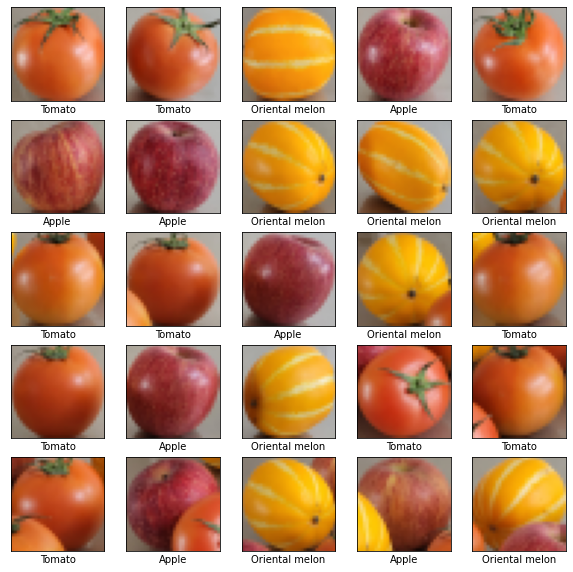

In [ ]:
# training dataset에 있는 sample 이미지를 확인한다.
show_number = len(train_images)
print('Tatal number of Images : %d' % show_number)
if (show_number > 25 ):
  show_number = 25
show_sample(train_images, 
            ['%s' % classes[np.argmax(label)] for label in train_labels], show_number)

Tatal number of Images : 29


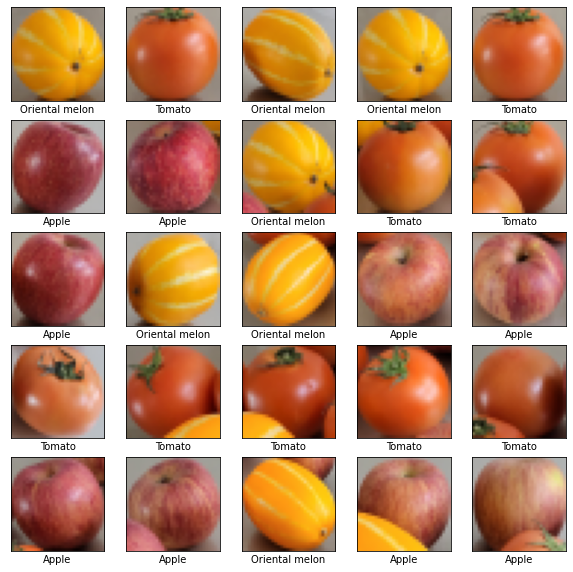

In [ ]:
# test dataset에 있는 sample 이미지를 확인한다.
show_number = len(test_images)
print('Tatal number of Images : %d' % show_number)
if (show_number > 25 ):
  show_number = 25
show_sample(test_images, 
            ['%s' % classes[np.argmax(label)] for label in test_labels], show_number)

#4. Model Training
We use Keras API to build a TensorFlow model that can classify the digit images. Please see this [tutorial](https://www.tensorflow.org/beta/tutorials/keras/basic_classification) if you are interested to learn more about how to build machine learning model with Keras and TensorFlow.

In [ ]:
# Define the model architecture
inputShape = (CH, CW, CD)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=inputShape),

    # keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Reshape(target_shape=inputShape),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),

		# softmax classifier
		keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Save the best model as fruit_custom.h5
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name, save_best_only=True)

# Define a callback to monitor val_loss
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                       patience=5)

In [ ]:
# Train the model using the early stopping callback
history = model.fit(train_images, train_labels, 
                    validation_data=(test_images, test_labels),
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[modelCheckpoint])

Epoch 1/100
1/1 [==============================] - 30s 30s/step - loss: 1.1122 - accuracy: 0.3976 - val_loss: 2.4509 - val_accuracy: 0.4138
Epoch 2/100
1/1 [==============================] - 0s 57ms/step - loss: 2.3237 - accuracy: 0.4337 - val_loss: 0.9635 - val_accuracy: 0.5862
Epoch 3/100
1/1 [==============================] - 0s 58ms/step - loss: 1.0810 - accuracy: 0.3494 - val_loss: 1.0814 - val_accuracy: 0.5862
Epoch 4/100
1/1 [==============================] - 0s 60ms/step - loss: 1.2198 - accuracy: 0.3976 - val_loss: 0.9914 - val_accuracy: 0.5172
Epoch 5/100
1/1 [==============================] - 0s 59ms/step - loss: 1.1070 - accuracy: 0.4458 - val_loss: 0.8847 - val_accuracy: 0.5862
Epoch 6/100
1/1 [==============================] - 0s 59ms/step - loss: 0.9340 - accuracy: 0.5301 - val_loss: 0.8229 - val_accuracy: 0.6897
Epoch 7/100
1/1 [==============================] - 0s 63ms/step - loss: 0.8428 - accuracy: 0.6988 - val_loss: 0.7832 - val_accuracy: 0.8966
Epoch 8/100
1/1 [===

In [ ]:
# 학습된 모델 다운로드
download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#5. Evaluate model
We run our digit classification model against our test dataset that the model hasn't seen during its training process. We want to confirm that the model didn't just remember the digits it saw but also generalize well to new images.

1/1 [==============================] - 0s 24ms/step - loss: 0.0200 - accuracy: 1.0000
Test accuracy: 1.0


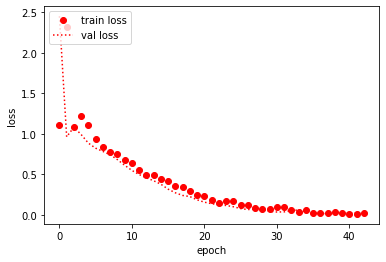

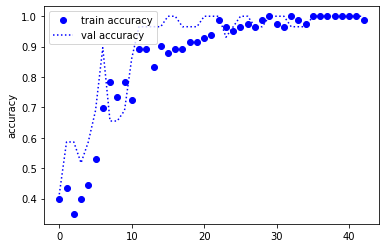

In [ ]:
# Evaluate the model using test dataset.
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

fig, loss_ax = plt.subplots()
fig, acc_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'ro', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r:', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'bo', label='train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'b:', label='val accuracy')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

#6. Prediction

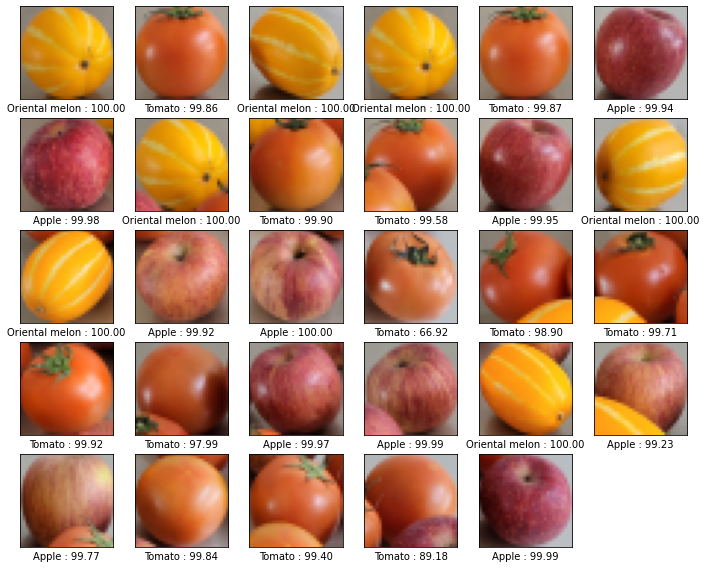

In [ ]:
# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_images)

# Then plot the first 25 test images and their predicted labels.
show_sample(test_images, 
            ['%s : %.2f' % (classes[np.argmax(result)], result[np.argmax(result)]*100) for result in predictions], 
            len(predictions))

Oriental melon : 100.00


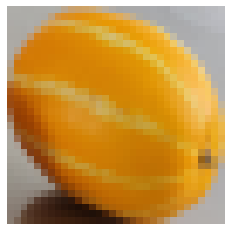

In [ ]:
# Predict Model
selected_digit = 2

result = predictions[selected_digit]
result_number = np.argmax(result)
print('%s : %.2f' % (classes[result_number], result[result_number]*100))

imShow(test_images[selected_digit])